In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math
import random
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
import scipy.spatial as ss
from math import log
import itertools
import operator
import ast
import collections

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists,mcrobie_djfjja_0,mcrobie_five_0

from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

# Import Datasets

In [2]:
# Import datasets with zeroes 
five_month_0 = mcrobie_five_0()
five_monthly_0 = five_month_0[1:]

# With zeros extracted
five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

Order: date, nw, nee, mc, io, eep, ism, easm
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


In [3]:
names = ['NW_Aus', 'NE_Aus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [x for x in range(7)]

permutation_names = []
for i,j in itertools.combinations(regions,2):
    name = [names[i],names[j]]
    permutation_names.append(name)

# Cross-Link Methods

In [5]:
def ordpat_strings(time_series,window_length,embedding_delay,block=False):
    if block==False:
        regional_sequence = regional_ordinal_sequence(time_series,window_length,embedding_delay)
    
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')
    
    elif  block==True:
        regional_sequence  = block_ordinal_sequence(time_series,window_length)
        
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')
            
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq
    
def co_occur_frequency(region1,region2,pattern_length,greater_than_value,show_zero=False):
    '''
    Find how each pattern in the ordinal sequence of region1 is distributed amonst the co-occurrences in region2
    
    Inputs:
        region1 = ordinal sequence for first region
        region2 = ordinal sequence for second region
        pattern_length = length of the ordinal pattern of interest
        greater_than_value = filter dictionary by co-occurrence greater than or equal to this value
        show_zero = True -> show all (pattern_lenth!)**2 pattterns including those which occur 0 times
                    False ->  only show patterns which occur >0 times
        
    Returns:
        List of dictionaries with distribution of each ordinal pattern co-occurrence
    '''
    admissible = [''.join(str(list(i)).split(',')) for i in  list(itertools.permutations([i for i in range(pattern_length)]))]
    admissible_co_occurrences = list(itertools.product(admissible, repeat=2))
    
    test = co_occur(region1, region2)
    freqs = count_frequency(test)
    
    if show_zero==False:
        filtered_dict = {k: v for (k,v) in freqs.items() if v >= greater_than_value}
        #return sorted(filtered_dict.items())
        return filtered_dict
    else:
        for i in range(len(admissible_co_occurrences)):
            potential = admissible_co_occurrences[i]
            if potential not in freqs.keys():
                freqs[potential] = 0
        return sorted(freqs.items())
    
def cross_links_simple(region_1,region_2,window_length,co_occurring_threshold):
    '''
    Calculate the number of co-occurring patterns
    
    Inputs:
        1) ordinal_sequence_region_1 = ordinal sequence corresponding to region 1 (the result of regional_ordinal_sequence() or block_ordinal_sequence())
        2) ordinal_sequence_region_2 = ordinal sequence corresponding to region 2
        3) window_length = ordinal partition window length, D corresponding to the sequence above
        4) co_occurrence_threshold = threshold for a co-occurring pattern to be prescribed
    '''  
    freqs = co_occur_frequency(region_1,region_2,window_length,co_occurring_threshold,False)
    #print(freqs)
    coupling_strength = len(freqs)
    
    return coupling_strength

# Surrogate Functions

In [6]:
def white_noise_surrogates(original_data):
    '''
    Return a shuffled copy of a time series array.

    Each time series is shuffled individually. The surrogates correspond to
    realizations of white noise consistent with the :attr:`original_data`
    time series' amplitude distribution.
    '''
    
    shuffle = random.shuffle
    surrogate = original_data.copy()
    for i in range(surrogate.shape[0]):
        shuffle(surrogate[i,:])
    return surrogate

In [7]:
def chopped(region_input,block_length):
    chop = []
    for i in range(len(region_input)):
        time_series = list(region_input[i])
        chunked_list = [time_series[i:i+block_length] for i in range(0, len(time_series), block_length)]
        for j in range(len(chunked_list)):
            act_len = len(chunked_list[j])
            if act_len != block_length:
                chunked_list.remove(chunked_list[j])
            else:
                pass
        chop.append(chunked_list)
    
    full_indices = []
    for i in range(len(chop)):
        component_indices = []
        for j in range(len(chunked_list[i])):
            component_indices.append(j)
        full_indices.append(component_indices)

    return np.asarray(full_indices),np.asarray(chop)

In [8]:
def chopped_surrogate(region_input,block_length): ## USES ONLY THE WHITE NOISE ALGORITHM
    sliced_indices,sliced_values = chopped(region_input,block_length) # Chop up all time series into blocks of length block_length
    
    orders = []
    for i in range(len(sliced_values)):
        block = sliced_values[i]
        
        block_index = []
        for j in range(len(block)):
            block_index.append(j)
        orders.append(block_index)
    
    shuffled = np.asarray(orders)
    surrogates = white_noise_surrogates(shuffled)
    
    shuffled_all = []
    for i in range(len(surrogates)):
        orders = surrogates[i]
        shuffled_component = []
        for j in range(len(orders)):
            value = sliced_values[i][orders[j]]
            shuffled_component.append(value)
        shuffled_all.append(shuffled_component)
    
    for i in range(len(shuffled_all)):
        shuffled_all[i] = np.hstack(shuffled_all[i])
        
    return shuffled_all

# Plotting Functions

In [9]:
def connections_summary_for_plot(connections_raw):
    connections_test = []
    edge_from_test = []
    edge_to_test = []
    for i in range(len(connections_raw)):
        if connections_raw[i][1] == 1:
            begin = connections_raw[i][0][0]
            end = connections_raw[i][0][1]
            value = 1
            
            edge_from_test.append(begin)
            edge_to_test.append(end)
            connections_test.append(value)
        else:
            pass
    return edge_from_test,edge_to_test

def nodes_latlon_dict():
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l') #requires initialisation of the map
    
    region_names = ['NW_Aus','NE_Aus','MC','IO','EEP','ISM','EASM']
    region_lat = [-15.000000,-15.000000,-2.500000,-7.500000,5.000000,15.000000,15.000000]
    region_lon = [127.500000,145.000000,120.000000,52.500000,240.000000,85.000000,110.000000]
    mx,my = m(region_lon,region_lat)
    
    coords =list(tuple(zip(mx,my)))
    pos = dict(zip(region_names,coords))
    
    return pos

def network_map_plot(connections_summary_input):
    pos = nodes_latlon_dict()
    test_graph = connections_summary_for_plot(connections_summary_input)
    
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l')
   
    G = nx.Graph()
    
    for i in range(len(test_graph[0])):
        begin = test_graph[0][i]
        end = test_graph[1][i]
        G.add_edge(begin,end)
    
    plt.figure(figsize=(12,15))
    
    nx.draw_networkx(G,pos,node_size=100,node_color='red',with_labels=False,width=1.5)
    
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-40.,41.,10.),
                    labels=[True,True,False,False],
                    dashes=[2,2],
                    linewidth=0.0)
    m.drawmeridians(np.arange(40.,260.,20.),
                    labels=[False,False,False,True],
                    dashes=[2,2],
                    linewidth=0.0)
    plt.show();

In [11]:
n_trials = 1000
shuffle_block_length = 12 #Shuffle by monsoon season of 3 months

# Original Cross-Links Implementation

In [14]:
def chopped_surrogate_testing_crosslinks(region_input,n_trials,window_length,block_length,co_occur_threshold): # Input original region_input (function applies chopped_surrogate())
    #print('Using "white_noise_surrogates" algorithm.')
    n_tests = 21

    test_distribution = np.zeros((n_tests+1,n_trials))
    
    for i in tqdm(range(n_trials)):
        surrogate_input = chopped_surrogate(region_input,block_length) # Raw time series
        surrogate_ord_seq = ordpat_strings(surrogate_input,window_length,1,True) # Arbitrarily set embedding delay 1, since block==True
        counter = 0
        for a,b in itertools.combinations(regions,2):
            count = cross_links_simple(surrogate_ord_seq[a],surrogate_ord_seq[b],window_length,co_occur_threshold)
            counter +=1 
            test_distribution[counter][i] = count
            
    test_distribution = np.delete(test_distribution,0,0)
    
    return test_distribution

def return_statistical_significance_crosslinks(actual_results,test_results,sig_level): # Actual = actual time series, theory = simulation surrogates
    names = ['NW_Aus','NE_Aus','MC','IO','EEP','ISM','EASM']
    permutation_names = []
    for i,j in itertools.combinations(regions,2):
        name = [names[i],names[j]]
        permutation_names.append(name)
    
    region_compare_percentile = []
    for i in range(len(test_results)):
        percentile = np.percentile(test_results[i],sig_level)
        region_compare_percentile.append(percentile)
    
    synchronisation = []
    for i in range(len(test_results)):
        if region_compare_percentile[i] >= actual_results[i]:
            synchronisation.append(1)
        else:
            synchronisation.append(0)
    return list(zip(permutation_names,synchronisation))

In [15]:
patterns_5 = ordpat_strings(five_monthly,5,1,True)

actual_results_5 = []
for i,j in itertools.combinations(regions,2):
    num = cross_links_simple(patterns_5[i],patterns_5[j],5,1)
    actual_results_5.append(num)

test_results_5 = chopped_surrogate_testing_crosslinks(five_monthly,1000,5,5,1)

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.44it/s]


(['NW_Aus', 'NE_Aus'], 0)
(['NW_Aus', 'MC'], 0)
(['NW_Aus', 'IO'], 1)
(['NW_Aus', 'EEP'], 1)
(['NW_Aus', 'ISM'], 1)
(['NW_Aus', 'EASM'], 1)
(['NE_Aus', 'MC'], 1)
(['NE_Aus', 'IO'], 1)
(['NE_Aus', 'EEP'], 1)
(['NE_Aus', 'ISM'], 0)
(['NE_Aus', 'EASM'], 1)
(['MC', 'IO'], 1)
(['MC', 'EEP'], 0)
(['MC', 'ISM'], 0)
(['MC', 'EASM'], 1)
(['IO', 'EEP'], 0)
(['IO', 'ISM'], 0)
(['IO', 'EASM'], 0)
(['EEP', 'ISM'], 1)
(['EEP', 'EASM'], 0)
(['ISM', 'EASM'], 1)


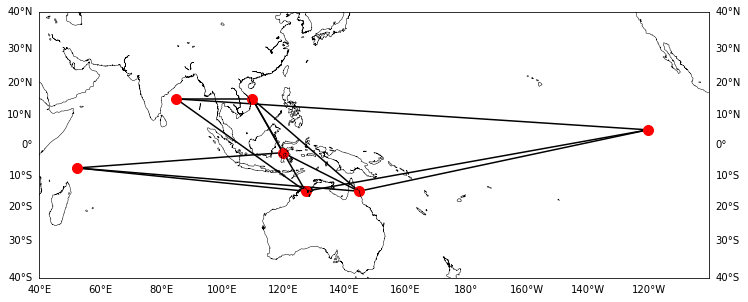

In [16]:
stat_results_5 = return_statistical_significance_crosslinks(actual_results_5,test_results_5,30)
for i in range(len(stat_results_5)):
    print(stat_results_5[i])
network_map_plot(stat_results_5)

# Add Noise to Time Series

In [17]:
def add_noise(regional_block,snr):
    noisy_block = np.zeros((7,len(regional_block[0])))
    for i in range(len(regional_block)):
        time_series = regional_block[i]
        series_mean = np.mean(five_monthly[i]) # Mean without zeros
        
        noisy_time_series = []
        for j in range(len(time_series)):
            random_noise = np.random.normal(0,series_mean*snr)
            
            if time_series[j] != 0:
                perturbed_obs = time_series[j] + random_noise
                noisy_block[i][j] = perturbed_obs
            else:
                noisy_block[i][j] = 0
    
    return noisy_block

## Sweep over increasing signal-noise ratios 

Cross-Links with Noise level: 0.4
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.52it/s]


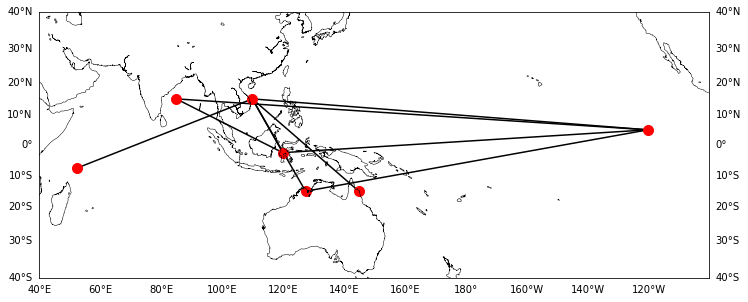

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.07it/s]


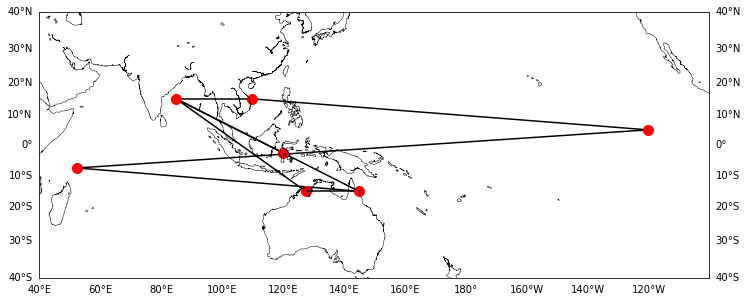

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.38it/s]


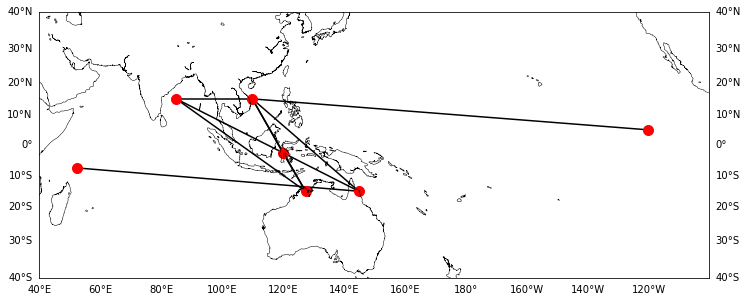

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.02it/s]


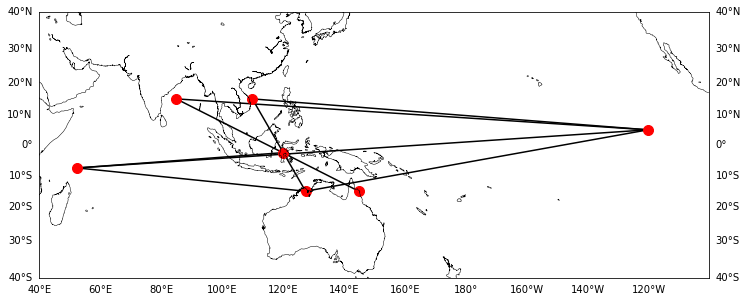

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.22it/s]


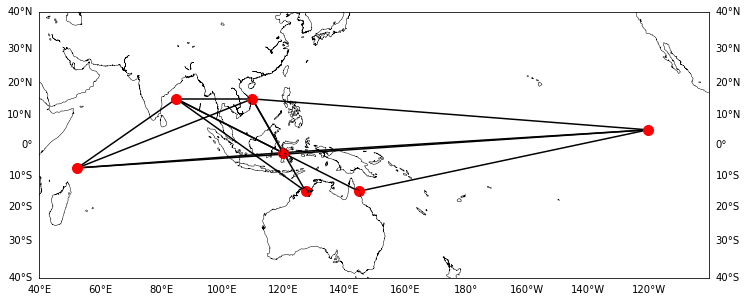

Cross-Links with Noise level: 0.5
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.99it/s]


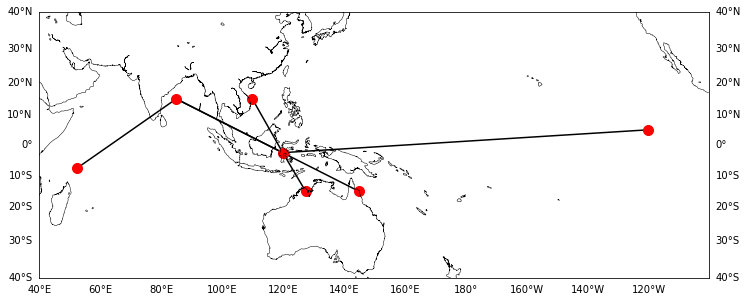

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.90it/s]


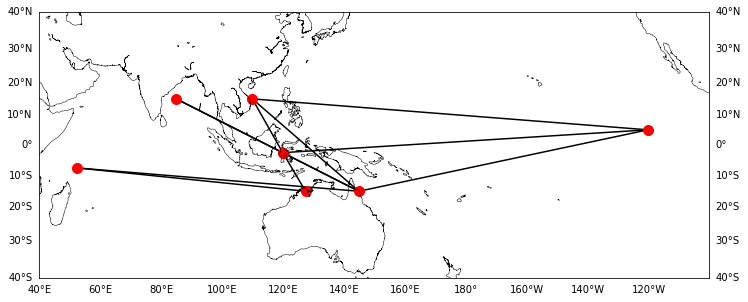

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.72it/s]


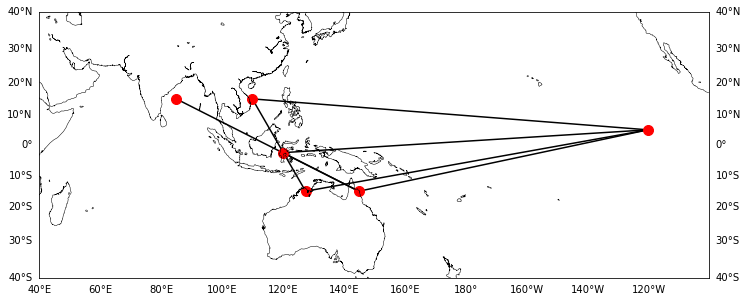

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.13it/s]


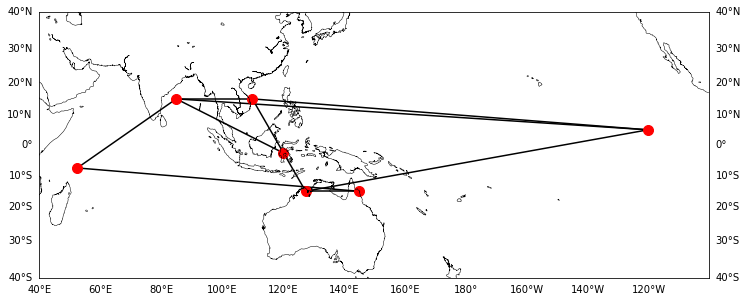

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


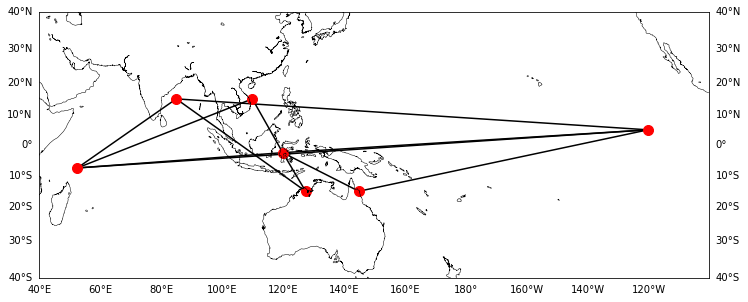

Cross-Links with Noise level: 0.6
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.40it/s]


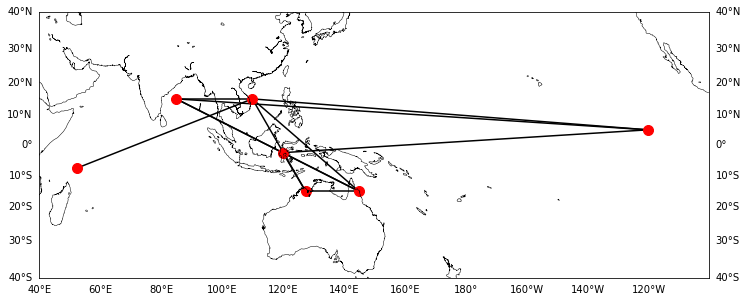

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.17it/s]


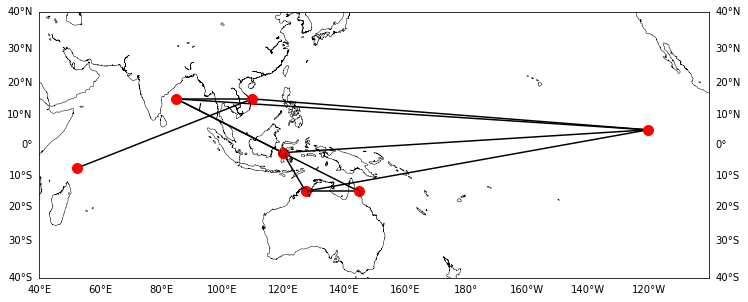

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.26it/s]


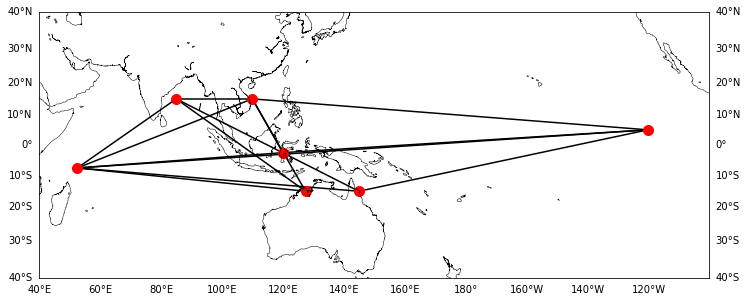

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.19it/s]


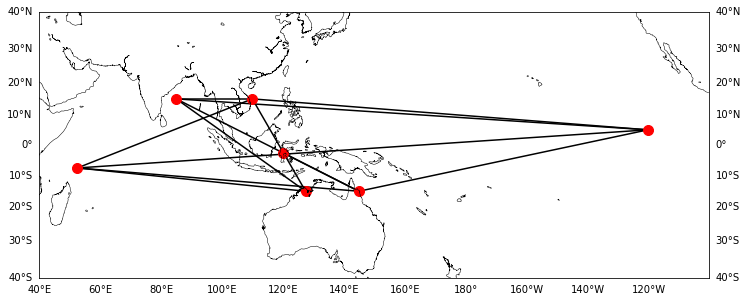

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.26it/s]


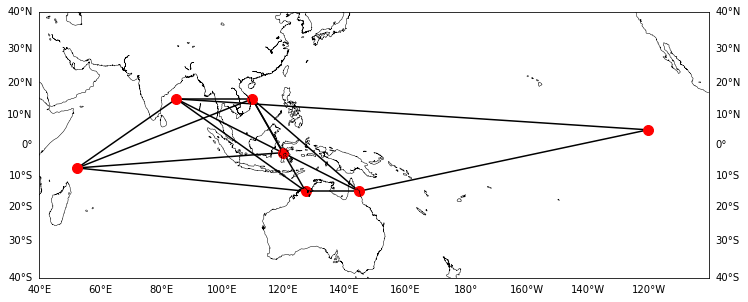

Cross-Links with Noise level: 0.7
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


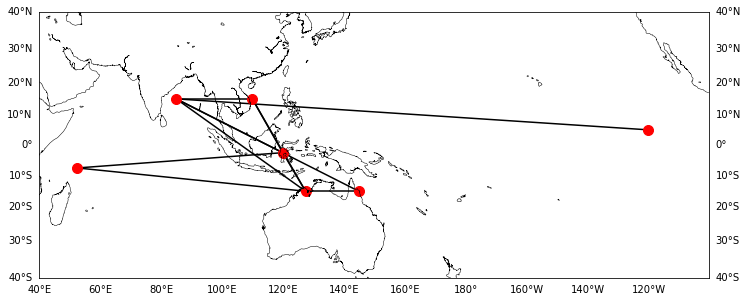

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.13it/s]


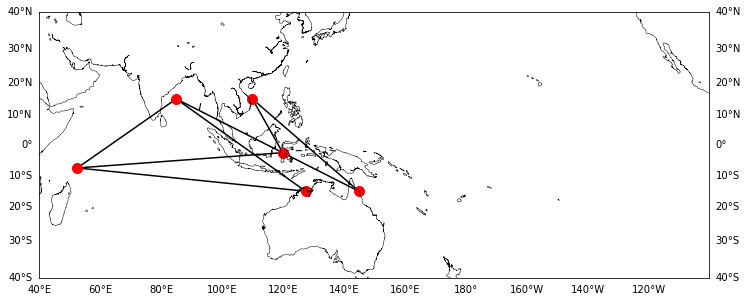

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.27it/s]


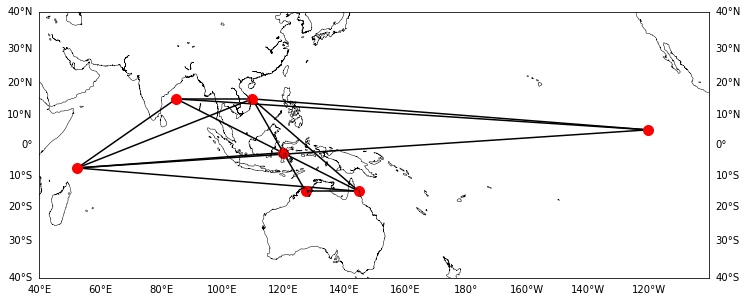

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.88it/s]


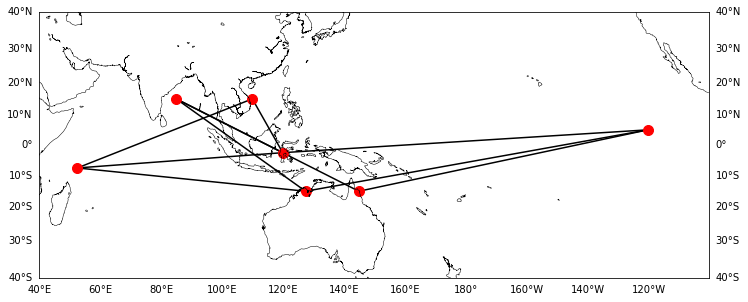

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.60it/s]


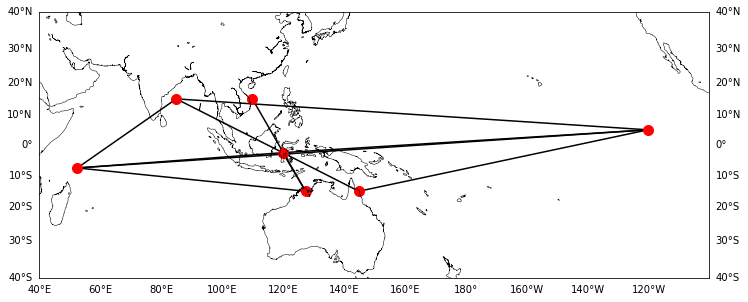

Cross-Links with Noise level: 1.0
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.75it/s]


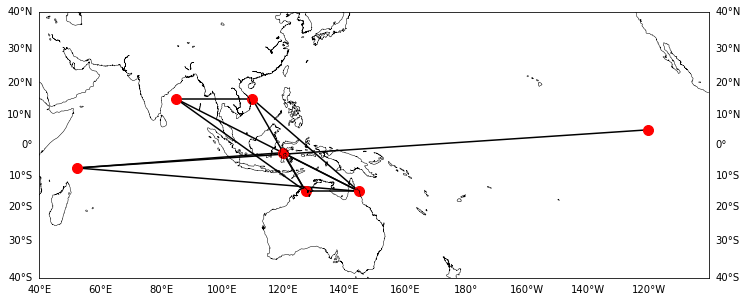

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.33it/s]


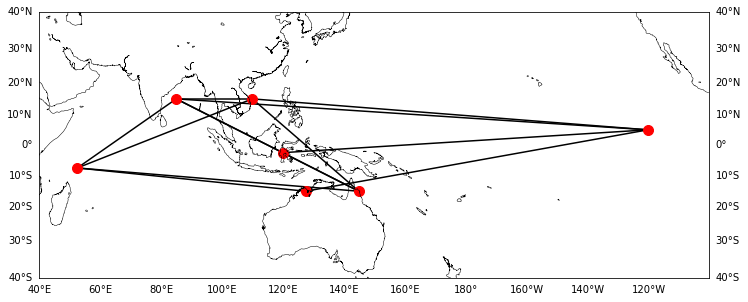

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.32it/s]


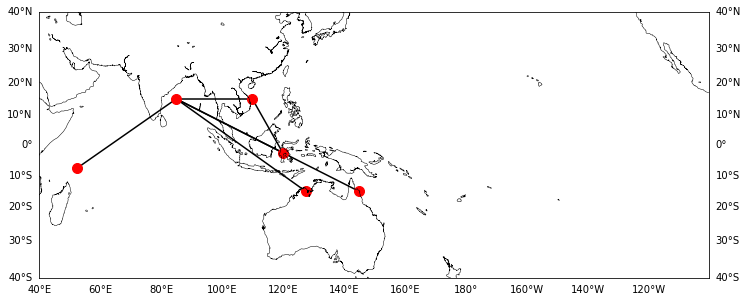

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.60it/s]


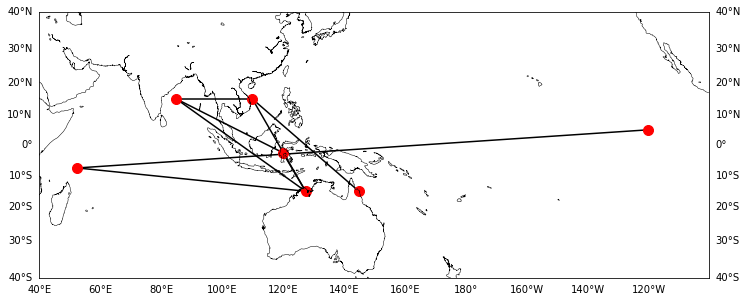

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]


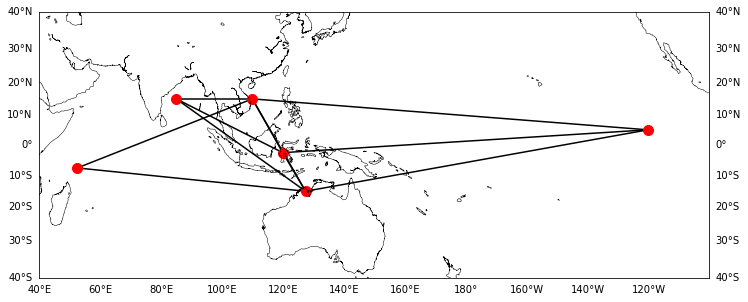

Cross-Links with Noise level: 2.0
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.83it/s]


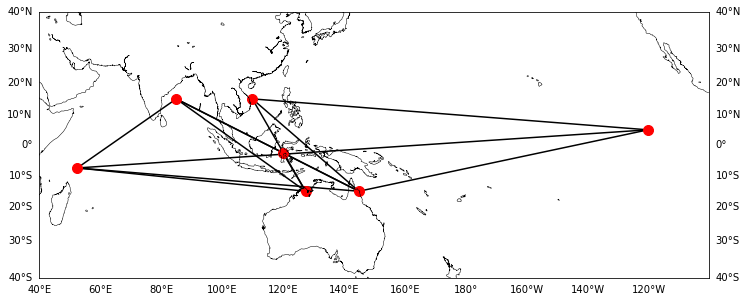

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.95it/s]


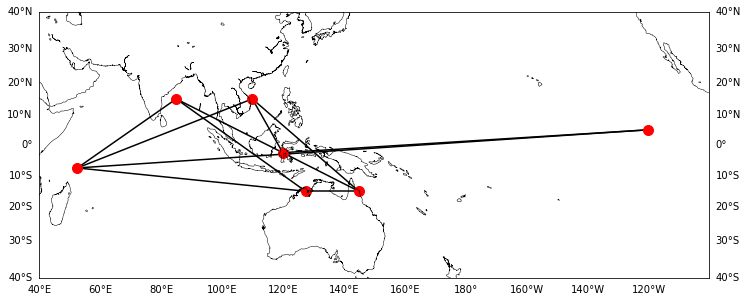

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.79it/s]


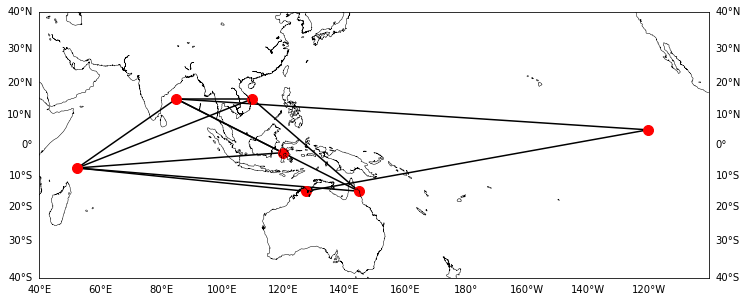

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.97it/s]


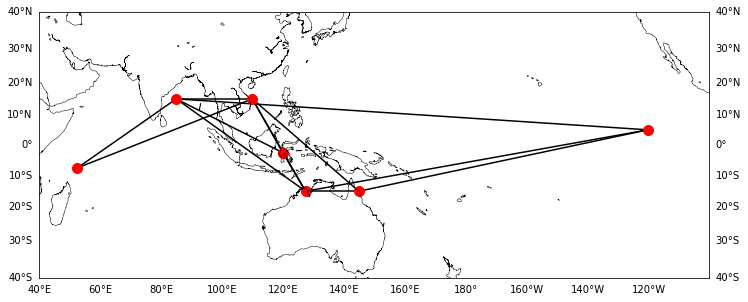

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.99it/s]


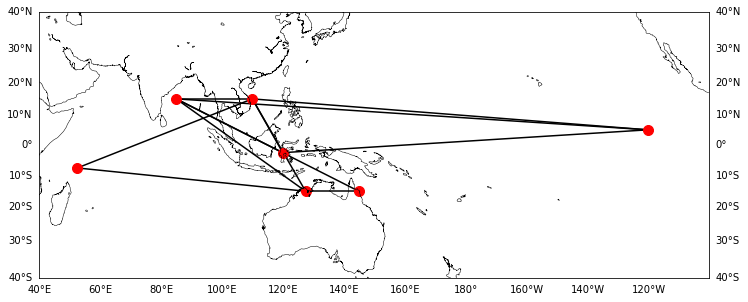

In [28]:
snrs = [0.4,0.5,0.6,0.7,1.0,2.0]
for i in range(len(snrs)):
    snr = snrs[i]
    print(f'Cross-Links with Noise level: {snr}')
    
    for j in range(5):
        example_noise = add_noise(five_monthly,snr)
        example_noisy_ordpat = ordpat_strings(example_noise,5,1,True)
        
        actual_noisy_cl = []
        for i,j in itertools.combinations(regions,2):
            num = cross_links_simple(example_noisy_ordpat[i],example_noisy_ordpat[j],5,1)
            actual_noisy_cl.append(num)
        
        test_noisy_cl = chopped_surrogate_testing_crosslinks(example_noise,1000,5,5,1)
        
        test_cl_results = return_statistical_significance_crosslinks(actual_noisy_cl,
                                                                     test_noisy_cl,
                                                                     40)
        network_map_plot(test_cl_results)